# Import

## Import libraries

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import os
import matplotlib.pyplot as plt

## Import LST20 Dataset

In [ ]:
!gdown --id 1aQDNH0M8Xg6bIG4Ao_-BMF3a8Or3-sVz

Downloading...
From: https://drive.google.com/uc?id=1aQDNH0M8Xg6bIG4Ao_-BMF3a8Or3-sVz
To: /content/LST20.tar.gz
100% 12.3M/12.3M [00:00<00:00, 33.5MB/s]


In [ ]:
!tar -xf '/content/LST20.tar.gz'
print("Extraction complete")

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemDownloadedDate'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.FinderInfo'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keywor

## Import test data

In [ ]:
!gdown --id 1DGdq4y8NA1N1besV-EYF6mwCQQMMCZa_

Downloading...
From: https://drive.google.com/uc?id=1DGdq4y8NA1N1besV-EYF6mwCQQMMCZa_
To: /content/ws_test.txt
100% 106k/106k [00:00<00:00, 59.9MB/s]


## Set path

In [ ]:
TRAINPATH = 'LST20_Corpus/train/'
TESTPATH = 'ws_test.txt'
EVALPATH = 'LST20_Corpus/eval/'

# Define function

## Define makelongsentence

In [ ]:
def makeLongSentence(txtFolder):
  '''
  Concatenate all character in LST20 dataset into one long sentence
  Input:
  txtFolder -> Path to FOLDER where all .txt file is kept
  Output:
  sentence_list -> A list of sentences from each .txt file in 'txtFolder'
  '''
  sentence_list = []
  for file in tqdm(os.listdir(txtFolder)):
    if not file.startswith('.'): #We can't read file that starts with ., so we just skip
      dataDict = {'Input':'', 'Solution':''}
      contdf = pd.read_csv(txtFolder+file, sep='\t', header=None, quotechar="|")
      contdf.columns = ['Word','POS','NER','Sentence']
      dataDict['Input'] = contdf['Word'].sum().replace('_',' ')
      dataDict['Solution'] = '|'.join(contdf['Word'].map(lambda x: x.replace('_',' ')))
      sentence_list.append(dataDict)
  return sentence_list

In [ ]:
help(makeLongSentence)

Help on function makeLongSentence in module __main__:

makeLongSentence(txtFolder)
    Concatenate all character in LST20 dataset into one long sentence
    Input:
    txtFolder -> Path to FOLDER where all .txt file is kept
    Output:
    sentence_list -> A list of sentences from each .txt file in 'txtFolder'



## Define evaluation method

In [ ]:
solstr = 'สวัสดี|ครับ|ท่าน|สมาชิก|ชมรม|คน|ชอบ|โค้ด'

In [ ]:
inpstr = 'สวัสดี|ครับท่าน|สมา|ชิก|ชมรม|คน|ชอบ|โค้ด'

In [ ]:
def checkAnswer(inpstr, solstr, showmistake = False, unioncut = False):
  '''
  Show statistics (including F1-score) for NLP word segmentation problem
  Input:
  inpstr -> Result from your model. Example: 'สวัสดี|ครับ|ท่าน|สมาชิก|ชมรม|คน|ชอบ|โค้ด'
  solstr -> Solution from evaluation set. (Same format as 'inpstr')
  Output:
  A dictionary with the following keys and values
  F1 -> F1-Score for NLP word segmentation problem
  Inpinsert -> Cutting point found in 'inpstr', but not in 'solstr'
  Match -> Cutting point found in both 'inpstr' and 'solstr'
  Precision -> Precision of your model
  Recall -> Recall of your model
  Solinsert -> Cutting point found in 'solstr', but not in 'inpstr'
  '''
  match = 0
  solinsert = 0
  inpinsert = 0
  solindex = 0
  inpindex = 0
  unionout = ''
  solcut = []

  def mistaken(inpindex, solindex, window = 5):
    inpmiss = ' '.join(str(inpindex-window)+'  ' + inpstr[inpindex-window:inpindex+window+1] + '  ' + str(inpindex+window+1))
    solmiss = ' '.join(str(solindex-window)+'  ' + solstr[solindex-window:solindex+window+1] + '  ' + str(solindex+window+1))
    return inpmiss+'\n'+solmiss+'\n'

  while (solindex<len(solstr) or inpindex<len(inpstr)):
    #print("Matching %s with %s" % (inpstr[inpindex],solstr[solindex]))
    if solstr[solindex]=='|' or inpstr[inpindex]=='|':
      if unioncut: unionout = unionout + '|'
      if solstr[solindex]=='|' and inpstr[inpindex]=='|':
        match = match+1
        solcut.append(True)
        solindex = solindex+1
        inpindex = inpindex+1
      elif solstr[solindex]=='|' and inpstr[inpindex]!='|':
        solcut.append(True)
        solinsert = solinsert+1
        solindex = solindex+1
        if showmistake: print(mistaken(inpindex,solindex))
      elif solstr[solindex]!='|' and inpstr[inpindex]=='|':
        solcut.append(False)
        inpinsert = inpinsert+1
        inpindex = inpindex+1
        if showmistake: print(mistaken(inpindex,solindex))
    else:
      if unioncut: unionout = unionout + solstr[solindex]
      solindex = solindex+1
      inpindex = inpindex+1
  
  precision = match/(match+inpinsert)
  recall = match/(match+solinsert)
  F1 = 2*precision*recall/(precision+recall)
  if unionout == '':
    union = None
    cutsol = []
  else:
    union = unionout
    cutsol = solcut
  union = None if unionout == '' else unionout
  return {'Match':match, 'Solinsert':solinsert, 'Inpinsert':inpinsert, 
          'Precision':precision,'Recall':recall,'F1':F1, 'Union':union, 'Cut solution':cutsol}

In [ ]:
checkAnswer(inpstr, solstr, showmistake=True,unioncut=False)

6     | ค ร ั บ ท ่ า น | ส     1 7
7     ค ร ั บ | ท ่ า น | ส     1 8

1 5     | ส ม า | ช ิ ก | ช ม     2 6
1 5     น | ส ม า ช ิ ก | ช ม     2 6



{'Cut solution': [],
 'F1': 0.8571428571428571,
 'Inpinsert': 1,
 'Match': 6,
 'Precision': 0.8571428571428571,
 'Recall': 0.8571428571428571,
 'Solinsert': 1,
 'Union': None}

## Define function for training DeepCut

In [ ]:
CHAR_TYPE = {
    u'กขฃคฆงจชซญฎฏฐฑฒณดตถทธนบปพฟภมยรลวศษสฬอ': 'c',
    u'ฅฉผฟฌหฮ': 'n',
    u'ะาำิีืึุู': 'v',  # า ะ ำ ิ ี ึ ื ั ู ุ
    u'เแโใไ': 'w',
    u'่้๊๋': 't', # วรรณยุกต์ ่ ้ ๊ ๋
    u'์ๆฯ.': 's', # ์  ๆ ฯ .
    u'0123456789๑๒๓๔๕๖๗๘๙': 'd',
    u'"': 'q',
    u"‘": 'q',
    u"’": 'q',
    u"'": 'q',
    u' ': 'p',
    u'abcdefghijklmnopqrstuvwxyz': 's_e',
    u'ABCDEFGHIJKLMNOPQRSTUVWXYZ': 'b_e'
}

CHAR_TYPE_FLATTEN = {}
for ks, v in CHAR_TYPE.items():
    for k in ks:
        CHAR_TYPE_FLATTEN[k] = v
CHARS = [
    u'\n', u' ', u'!', u'"', u'#', u'$', u'%', u'&', "'", u'(', u')', u'*', u'+',
    u',', u'-', u'.', u'/', u'0', u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8',
    u'9', u':', u';', u'<', u'=', u'>', u'?', u'@', u'A', u'B', u'C', u'D', u'E',
    u'F', u'G', u'H', u'I', u'J', u'K', u'L', u'M', u'N', u'O', u'P', u'Q', u'R',
    u'S', u'T', u'U', u'V', u'W', u'X', u'Y', u'Z', u'[', u'\\', u']', u'^', u'_',
    u'a', u'b', u'c', u'd', u'e', u'f', u'g', u'h', u'i', u'j', u'k', u'l', u'm',
    u'n', u'o', u'other', u'p', u'q', u'r', u's', u't', u'u', u'v', u'w', u'x', u'y',
    u'z', u'}', u'~', u'ก', u'ข', u'ฃ', u'ค', u'ฅ', u'ฆ', u'ง', u'จ', u'ฉ', u'ช',
    u'ซ', u'ฌ', u'ญ', u'ฎ', u'ฏ', u'ฐ', u'ฑ', u'ฒ', u'ณ', u'ด', u'ต', u'ถ', u'ท',
    u'ธ', u'น', u'บ', u'ป', u'ผ', u'ฝ', u'พ', u'ฟ', u'ภ', u'ม', u'ย', u'ร', u'ฤ',
    u'ล', u'ว', u'ศ', u'ษ', u'ส', u'ห', u'ฬ', u'อ', u'ฮ', u'ฯ', u'ะ', u'ั', u'า',
    u'ำ', u'ิ', u'ี', u'ึ', u'ื', u'ุ', u'ู', u'ฺ', u'เ', u'แ', u'โ', u'ใ', u'ไ',
    u'ๅ', u'ๆ', u'็', u'่', u'้', u'๊', u'๋', u'์', u'ํ', u'๐', u'๑', u'๒', u'๓',
    u'๔', u'๕', u'๖', u'๗', u'๘', u'๙', u'‘', u'’', u'\ufeff'
]
CHARS_MAP = {v: k for k, v in enumerate(CHARS)}

CHAR_TYPES = [
    'b_e', 'c', 'd', 'n', 'o',
    'p', 'q', 's', 's_e', 't',
    'v', 'w'
]
CHAR_TYPES_MAP = {v: k for k, v in enumerate(CHAR_TYPES)}

In [ ]:
from functools import reduce
def generate_words(files):
    """
    Transform list of files to list of words,
    removing new line character
    and replace name entity '<NE>...</NE>' and abbreviation '<AB>...</AB>' symbol
    """

    repls = {'<NE>' : '','</NE>' : '','<AB>': '','</AB>': ''}

    words_all = []
    for _, file in enumerate(files):
        lines = open(file, 'r')
        for line in lines:
            line = reduce(lambda a, kv: a.replace(*kv), repls.items(), line)
            words = [word for word in line.split("|") if word is not '\n']
            words_all.extend(words)
    return words_all

In [ ]:
from tqdm.notebook import tqdm
def create_char_dataframe(words):
    """
    Give list of input tokenized words,
    create dataframe of characters where first character of
    the word is tagged as 1, otherwise 0
    Example
    =======
    ['กิน', 'หมด'] to dataframe of
    [{'char': 'ก', 'type': ..., 'target': 1}, ...,
     {'char': 'ด', 'type': ..., 'target': 0}]
    """
    char_dict = []
    for word in tqdm(words):
        for i, char in enumerate(word):
            if i == 0:
                char_dict.append({'char': char,
                                  'type': CHAR_TYPE_FLATTEN.get(char, 'o'),
                                  'target': True})
            else:
                char_dict.append({'char': char,
                                  'type': CHAR_TYPE_FLATTEN.get(char, 'o'),
                                  'target': False})
    return pd.DataFrame(char_dict)
def create_n_gram_df(df, n_pad):
    """
    Given input dataframe, create feature dataframe of shifted characters
    """
    n_pad_2 = int((n_pad - 1)/2)
    for i in range(n_pad_2):
        df['char-{}'.format(i+1)] = df['char'].shift(i + 1)
        df['type-{}'.format(i+1)] = df['type'].shift(i + 1)
        df['char{}'.format(i+1)] = df['char'].shift(-i - 1)
        df['type{}'.format(i+1)] = df['type'].shift(-i - 1)
    return df[n_pad_2: -n_pad_2]

# Insert txt file to Create Dataset

In [ ]:
Allword = makeLongSentence('/content/train/LST20 (Main Resource)/LST20_Corpus/LST20_Corpus/train/')

{'Input': 'อดีตส.ส.อีสานปชป."ไขก๊อก" "ยุทธพงศ์"อ้างทบทวนตัวเอง"ยุทธพงศ์ จรัสเสถียร" มือปราบรถดับเพลิง อดีต ส.ส.มหาสารคาม ยื่นใบลาออกจาก ปชป. หลังอยู่ใต้ร่มเงานาน 10 ปี อ้างขอเวลาทบทวนตัวเองสักระยะ ปัดยังไม่คิดไปสังกัดพรรคอื่นนายยุทธพงศ์ จรัสเสถียร อดีต ส.ส.มหาสารคาม พรรคประชาธิปัตย์เปิดเผยว่า เมื่อเช้าวันที่ 13 กรกฎาคมที่ผ่านมา ได้ยื่นหนังสือลาออกจากการเป็นสมาชิกพรรคประชาธิปัตย์เป็นทางการแล้ว ถือว่ามีผลโดยสมบูรณ์นับตั้งแต่วันนี้เป็นต้นไป"ต้องขอบคุณพรรค ประชาธิปัตย์ ที่ทำให้ผมได้เกิด เติบโต และทำงานทางการเมืองมาตลอดระยะ 10 ปีเต็ม เนื่องจากวันนี้ ไม่ได้มีสถานะของความเป็น ส.ส. อีกทั้งเห็นว่า พรรคประชาธิปัตย์จนได้กลับมาเป็นรัฐบาลอีกครั้ง จึงตัดสินใจลาออก โดยไม่ได้มีความโกรธเคือง หรือน้อยเนื้อต่ำใจใดๆ เพียงแค่ต้องการกลับไปนั่งคิดและทบทวนเกี่ยวกับอนาคตทางการเมืองสักระยะ" นายยุทธพงศ์กล่าวผู้สื่อข่าวถามว่า มีการปรึกษาใครก่อนที่จะตัดสินใจหรือไม่นายยุทธพงศ์กล่าวว่า "ยอมรับว่าไม่ได้ปรึกษาใคร เป็นการตัดสินใจด้วยตัวเอง ต้องขอโทษผู้ใหญ่หลายๆ คนที่ให้โอกาส"เมื่อถามว่า เป็นเพราะขุดคุ้ยโครงการทุจริตการ

In [ ]:
Allword_eval = makeLongSentence('/content/train/LST20 (Main Resource)/LST20_Corpus/LST20_Corpus/eval/')

  0%|          | 0/949 [00:00<?, ?it/s]

In [ ]:
Longtext = []
for word in tqdm(Allword):
  Longtext = Longtext + word['Solution'].split('|')

  0%|          | 0/3794 [00:00<?, ?it/s]

In [ ]:
Longtext2 = []
for word in tqdm(Allword_eval):
  Longtext2 = Longtext2 + word['Solution'].split('|')

  0%|          | 0/474 [00:00<?, ?it/s]

In [ ]:
train_df_02 = create_char_dataframe(Longtext)

  0%|          | 0/2714726 [00:00<?, ?it/s]

In [ ]:
eval_df_02 = create_char_dataframe(Longtext2)

  0%|          | 0/240860 [00:00<?, ?it/s]

In [ ]:
train_df_02[:20]

,char,type,target
0,อ,c,True
1,ด,c,False
2,ี,v,False
3,ต,c,False
4,ส,c,True
5,.,s,False
6,ส,c,False
7,.,s,False
8,อ,c,True
9,ี,v,False


In [ ]:
# train_df_02.to_csv('/content/gdrive/MyDrive/test_df_02.csv', index=False)
eval_df_02.to_csv('/content/gdrive/MyDrive/eval_df_02.csv', index=False)

# Setting Model

In [1]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, \
    Concatenate, Flatten, SpatialDropout1D, \
    BatchNormalization, Conv1D, Maximum, ZeroPadding1D
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam

def conv_unit(inp, n_gram, no_word=200, window=2):
    out = Conv1D(no_word, window, strides=1, padding="valid", activation='relu')(inp)
    out = TimeDistributed(Dense(5, input_shape=(n_gram, no_word)))(out)
    out = ZeroPadding1D(padding=(0, window - 1))(out)
    return out

def get_convo_nn2(no_word=200, n_gram=21, no_char=178):
    input1 = Input(shape=(n_gram,))
    input2 = Input(shape=(n_gram,))

    a = Embedding(no_char, 32, input_length=n_gram)(input1)
    a = SpatialDropout1D(0.15)(a)
    a = BatchNormalization()(a)

    a_concat = []
    for i in range(1,9):
        a_concat.append(conv_unit(a, n_gram, no_word, window=i))
    for i in range(9,12):
        a_concat.append(conv_unit(a, n_gram, no_word - 50, window=i))
    a_concat.append(conv_unit(a, n_gram, no_word - 100, window=12))
    a_sum = Maximum()(a_concat)

    b = Embedding(12, 12, input_length=n_gram)(input2)
    b = SpatialDropout1D(0.15)(b)

    x = Concatenate(axis=-1)([a, a_sum, b])
    #x = Concatenate(axis=-1)([a_sum, b])
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input1, input2], outputs=out)
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy', metrics=['acc'])
    return model

# Create Custom Datagen แบบเท่ๆ

In [ ]:
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
class SaranDeepcutDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 shuffle=False):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        # self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_target = df[y_col].nunique()
        # self.n_type = df[y_col['type']].nunique()
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
       
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        n_pad = 21
        n_pad_2 = int((n_pad - 1)/2)
        pad = [{'char': ' ', 'type': 'p', 'target': True}]
        df_pad = pd.DataFrame(pad * n_pad_2)

        df = pd.concat((df_pad, batches, df_pad)) # pad with empty string feature

        df['char'] = df['char'].map(lambda x: CHARS_MAP.get(x, 80))
        df['type'] = df['type'].map(lambda x: CHAR_TYPES_MAP.get(x, 4))
        df_pad = create_n_gram_df(df, n_pad=n_pad)

        char_row = ['char' + str(i + 1) for i in range(n_pad_2)] + \
                ['char-' + str(i + 1) for i in range(n_pad_2)] + ['char']
        type_row = ['type' + str(i + 1) for i in range(n_pad_2)] + \
                ['type-' + str(i + 1) for i in range(n_pad_2)] + ['type']

        x_char = df_pad[char_row].to_numpy()
        x_type = df_pad[type_row].to_numpy()
        y = df_pad['target'].astype(int).to_numpy()

        return tuple([x_char, x_type]), y
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

# Training model ซักทีเถอะ

In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/test_df_02.csv')
valid_df = pd.read_csv('/content/gdrive/MyDrive/eval_df_02.csv')

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

filepath="DeepCut_Just_realize_the_truth.h5"
callbacks_list = [
    ReduceLROnPlateau(),
    ModelCheckpoint(
        filepath,
        save_best_only=True,
        # save_weights_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )
]


In [ ]:
from tensorflow import keras
model = get_convo_nn2()
model.load_weights('/content/deepcut_weight.h5')
model.summary()

In [ ]:
train_params = [(10,4096)]
for (epochs, batch_size) in train_params:
    traingen = SaranDeepcutDataGen(train_df,
                         X_col=['char','type'],
                         y_col='target',
                         batch_size=batch_size)

    validgen = SaranDeepcutDataGen(valid_df,
                         X_col=['char','type'],
                         y_col='target',
                         batch_size=batch_size)
    print("train with {} epochs and {} batch size".format(epochs, batch_size))
    model.fit(traingen,
              epochs=epochs,
              validation_data = validgen,
              verbose=1,
              callbacks=callbacks_list)

train with 7 epochs and 2048 batch size
Epoch 1/7
1133/5016 [=====>........................] - ETA: 3:47 - loss: 0.0201 - acc: 0.9930

In [ ]:
model.save('/content/DeepCut_Just_realize_the_truth_4096.h5')

# Load model

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/DeepCut_Just_realize_the_truth_4096.h5')

# Transform data into DeepCut-supported model

In [ ]:
import pandas as pd
def create_input_PangDeepcut_model(text):
  def create_n_gram_df(df, n_pad):
    """
    Given input dataframe, create feature dataframe of shifted characters
    """
    n_pad_2 = int((n_pad - 1)/2)
    for i in range(n_pad_2):
        df['char-{}'.format(i+1)] = df['char'].shift(i + 1)
        df['type-{}'.format(i+1)] = df['type'].shift(i + 1)
        df['char{}'.format(i+1)] = df['char'].shift(-i - 1)
        df['type{}'.format(i+1)] = df['type'].shift(-i - 1)
    return df[n_pad_2: -n_pad_2]
  CHAR_TYPE = {
    u'กขฃคฆงจชซญฎฏฐฑฒณดตถทธนบปพฟภมยรลวศษสฬอ': 'c',
    u'ฅฉผฟฌหฮ': 'n',
    u'ะาำิีืึุู': 'v',  # า ะ ำ ิ ี ึ ื ั ู ุ
    u'เแโใไ': 'w',
    u'่้๊๋': 't', # วรรณยุกต์ ่ ้ ๊ ๋
    u'์ๆฯ.': 's', # ์  ๆ ฯ .
    u'0123456789๑๒๓๔๕๖๗๘๙': 'd',
    u'"': 'q',
    u"‘": 'q',
    u"’": 'q',
    u"'": 'q',
    u' ': 'p',
    u'abcdefghijklmnopqrstuvwxyz': 's_e',
    u'ABCDEFGHIJKLMNOPQRSTUVWXYZ': 'b_e'
  }

  
  CHAR_TYPE_FLATTEN = {}
  for ks, v in CHAR_TYPE.items():
      for k in ks:
          CHAR_TYPE_FLATTEN[k] = v

  CHARS = [
    u'\n', u' ', u'!', u'"', u'#', u'$', u'%', u'&', "'", u'(', u')', u'*', u'+',
    u',', u'-', u'.', u'/', u'0', u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8',
    u'9', u':', u';', u'<', u'=', u'>', u'?', u'@', u'A', u'B', u'C', u'D', u'E',
    u'F', u'G', u'H', u'I', u'J', u'K', u'L', u'M', u'N', u'O', u'P', u'Q', u'R',
    u'S', u'T', u'U', u'V', u'W', u'X', u'Y', u'Z', u'[', u'\\', u']', u'^', u'_',
    u'a', u'b', u'c', u'd', u'e', u'f', u'g', u'h', u'i', u'j', u'k', u'l', u'm',
    u'n', u'o', u'other', u'p', u'q', u'r', u's', u't', u'u', u'v', u'w', u'x', u'y',
    u'z', u'}', u'~', u'ก', u'ข', u'ฃ', u'ค', u'ฅ', u'ฆ', u'ง', u'จ', u'ฉ', u'ช',
    u'ซ', u'ฌ', u'ญ', u'ฎ', u'ฏ', u'ฐ', u'ฑ', u'ฒ', u'ณ', u'ด', u'ต', u'ถ', u'ท',
    u'ธ', u'น', u'บ', u'ป', u'ผ', u'ฝ', u'พ', u'ฟ', u'ภ', u'ม', u'ย', u'ร', u'ฤ',
    u'ล', u'ว', u'ศ', u'ษ', u'ส', u'ห', u'ฬ', u'อ', u'ฮ', u'ฯ', u'ะ', u'ั', u'า',
    u'ำ', u'ิ', u'ี', u'ึ', u'ื', u'ุ', u'ู', u'ฺ', u'เ', u'แ', u'โ', u'ใ', u'ไ',
    u'ๅ', u'ๆ', u'็', u'่', u'้', u'๊', u'๋', u'์', u'ํ', u'๐', u'๑', u'๒', u'๓',
    u'๔', u'๕', u'๖', u'๗', u'๘', u'๙', u'‘', u'’', u'\ufeff'
  ]
  CHARS_MAP = {v: k for k, v in enumerate(CHARS)}

  CHAR_TYPES = [
      'b_e', 'c', 'd', 'n', 'o',
      'p', 'q', 's', 's_e', 't',
      'v', 'w'
  ]
  CHAR_TYPES_MAP = {v: k for k, v in enumerate(CHAR_TYPES)}

  char_dict = []
  for c in text:
      char_dict.append({'char': c,
                        'type': CHAR_TYPE_FLATTEN.get(c, 'o')})
  df_char_dict = pd.DataFrame(char_dict)
  n_pad = 21
  n_pad_2 = int((n_pad - 1)/2)
  pad = [{'char': ' ', 'type': 'p'}]
  df_pad = pd.DataFrame(pad * n_pad_2)

  df = pd.concat((df_pad, df_char_dict, df_pad)) # pad with empty string feature

  df['char'] = df['char'].map(lambda x: CHARS_MAP.get(x, 80))
  df['type'] = df['type'].map(lambda x: CHAR_TYPES_MAP.get(x, 4))
  df_pad = create_n_gram_df(df, n_pad=n_pad)

  char_row = ['char' + str(i + 1) for i in range(n_pad_2)] + \
          ['char-' + str(i + 1) for i in range(n_pad_2)] + ['char']
  type_row = ['type' + str(i + 1) for i in range(n_pad_2)] + \
          ['type-' + str(i + 1) for i in range(n_pad_2)] + ['type']

  x_char = df_pad[char_row].to_numpy()
  x_type = df_pad[type_row].to_numpy()
  return x_char,x_type

# Create function to transform and predict test data

In [ ]:
def ultimatePangCut(inputText):
  ws_test = inputText
  xchar_in,xtype_in = create_input_PangDeepcut_model(ws_test)
  y_predict = model.predict([xchar_in, xtype_in])
  y_predict_new = (y_predict.ravel() > 0.5).astype(int)

  list_index = []
  for ij in range(len(y_predict_new)):
    if y_predict_new[ij] == 1:
      list_index.append(ij)

  result = []
  result.append(ws_test[:list_index[0]])
  for ij in range(len(list_index)-1):
    result.append(ws_test[list_index[ij]:list_index[ij+1]])
  result.append(ws_test[list_index[-1]:])

  deepcut_result = '|'.join(result)
  if deepcut_result.startswith('|'):
    deepcut_result = deepcut_result[1:]
  return deepcut_result

# Example of a word segmentation by our model

In [ ]:
ultimatePangCut(eval_sentence[0]['Input'])

'แข้ง|บอล|โลก|ไทย|ได้|อันดับ| |10|ทีม| |นัก|เตะ|ไทย|พ่าย|บราซิล| |3-4| |ใน|การ|ดวล|จุด|โทษ| |หลัง|เสมอ|กัน|ใน|เวลา| |1-1| |ศึก|กีฬา|มหาวิทยาลัยโลก| |ฤดู|ร้อน| |ครั้ง|ที่| |25| |ที่|กรุงเบลเกรด| |ประเทศ|เซอร์เบีย| |เมื่อ|วันที่| |10| |กรกฎาคม| |ทำให้|ทีม|นัก|เตะ|ไทย|ได้|แค่|อันดับ| |10| |จาก|ครั้ง|ที่|แล้ว|ที่|ทีม|ไทย|คว้า|เหรียญ|ทองแดง|ได้|สรุป|เหรียญ|รางวัล|ล่า| |สุด| |จีน|ยัง|นำ|เป็น|จ่า|ฝูง| |18| |เหรียญ|ทอง| |20| |เหรียญ|เงิน| |13| |เหรียญ|ทองแดง| |ส่วน|ไทย|อยู่|อันดับ| |11:44| |ได้| |1| |เหรียญ|เงิน| |กับ|อีก| |6| |เหรียญ|ทองแดง'

# Model evaluation
The data is from LST20 evaluation set

In [ ]:
deep_stats = []
for oneSentence in tqdm(eval_sentence):
  deep_stats.append(checkAnswer(ultimatePangCut(oneSentence['Input']), oneSentence['Solution']))

100%|██████████| 474/474 [07:50<00:00,  1.01it/s]


In [ ]:
stats_df = pd.DataFrame(deep_stats)

In [ ]:
stats_df.sort_values('F1',ascending=True)

,Match,Solinsert,Inpinsert,Precision,Recall,F1,Union,Cut solution
373,57,2,5,0.919355,0.966102,0.942149,None,[]
23,226,5,18,0.926230,0.978355,0.951579,None,[]
417,59,5,1,0.983333,0.921875,0.951613,None,[]
208,219,2,17,0.927966,0.990950,0.958425,None,[]
436,82,4,2,0.976190,0.953488,0.964706,None,[]
...,...,...,...,...,...,...,...,...
58,59,0,0,1.000000,1.000000,1.000000,None,[]
52,219,0,0,1.000000,1.000000,1.000000,None,[]
228,268,0,0,1.000000,1.000000,1.000000,None,[]
182,213,0,0,1.000000,1.000000,1.000000,None,[]


Find average F1 score

In [ ]:
stats_df.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


Match        501.717300
Solinsert      5.426160
Inpinsert      7.447257
Precision      0.985686
Recall         0.989907
F1             0.987749
Union               NaN
dtype: float64

Plot boxplot for presentation

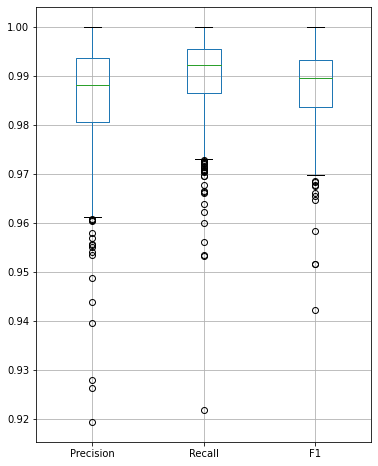

In [ ]:
plt.figure(figsize=(6,8))
stats_df.boxplot(column = ['Precision','Recall','F1'])

In [ ]:
checkAnswer(ultimatePangCut(eval_sentence[208]['Input']), eval_sentence[208]['Solution'], showmistake=True)

1     ห ภ า พ | ร ฟ ท . | แ     1 2
0     ส ห ภ า พ ร ฟ ท . | แ     1 1

6 8     | ก อ ง | ป ร า บ ป ร     7 9
6 6     ่ | ก อ ง ป ร า บ ป ร     7 7

1 1 7     ห ภ า พ | ร ั ฐ ว ิ ส     1 2 8
1 1 4     ส ห ภ า พ ร ั ฐ ว ิ ส     1 2 5

1 2 9     ห ก ิ จ | ร ถ ไ ฟ | แ     1 4 0
1 2 5     า ห ก ิ จ ร ถ ไ ฟ แ ห     1 3 6

1 3 4     ร ถ ไ ฟ | แ ห ่ ง | ป     1 4 5
1 2 9     จ ร ถ ไ ฟ แ ห ่ ง | ป     1 4 0

1 7 7     ร ถ ไ ฟ | แ ห ่ ง | ป     1 8 8
1 7 1     ร ร ถ ไ ฟ แ ห ่ ง | ป     1 8 2

2 5 0     | ก อ ง | บ ั ง ค ั บ     2 6 1
2 4 3     น | ก อ ง บ ั ง ค ั บ     2 5 4

3 2 1     ้ | ว ่ า ก า ร | ร ถ     3 3 2
3 1 5     | ว ่ า | ก า ร ร ถ ไ     3 2 6

3 2 5     า ก า ร | ร ถ ไ ฟ | แ     3 3 6
3 1 8     า | ก า ร ร ถ ไ ฟ แ ห     3 2 9

3 3 0     ร ถ ไ ฟ | แ ห ่ ง | ป     3 4 1
3 2 2     ร ร ถ ไ ฟ แ ห ่ ง | ป     3 3 3

3 6 6     | ก า ร | ร ถ ไ ฟ | แ     3 7 7
3 5 7     ร | ก า ร ร ถ ไ ฟ แ ห     3 6 8

3 7 1     ร ถ ไ ฟ | แ ห ่ ง | ป     3 8 2
3 6 1     ร ร ถ ไ ฟ แ ห ่ ง | ป     3 7 2



{'Cut solution': [],
 'F1': 0.9584245076586434,
 'Inpinsert': 17,
 'Match': 219,
 'Precision': 0.9279661016949152,
 'Recall': 0.9909502262443439,
 'Solinsert': 2,
 'Union': None}